# ARIMA Model on Electricity Production Forecasting

In [1]:
import pandas as pd
import pandas as pd, datetime
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt
from time import time
import os
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/content/Electric_Production.csv')
data.rename(columns={'IPG2211A2N': 'Production'}, inplace=True)
data.head()

,DATE,Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
# Checking missing value
data.isnull().sum()

DATE          0
Production    0
dtype: int64

### Visualizing the dataset



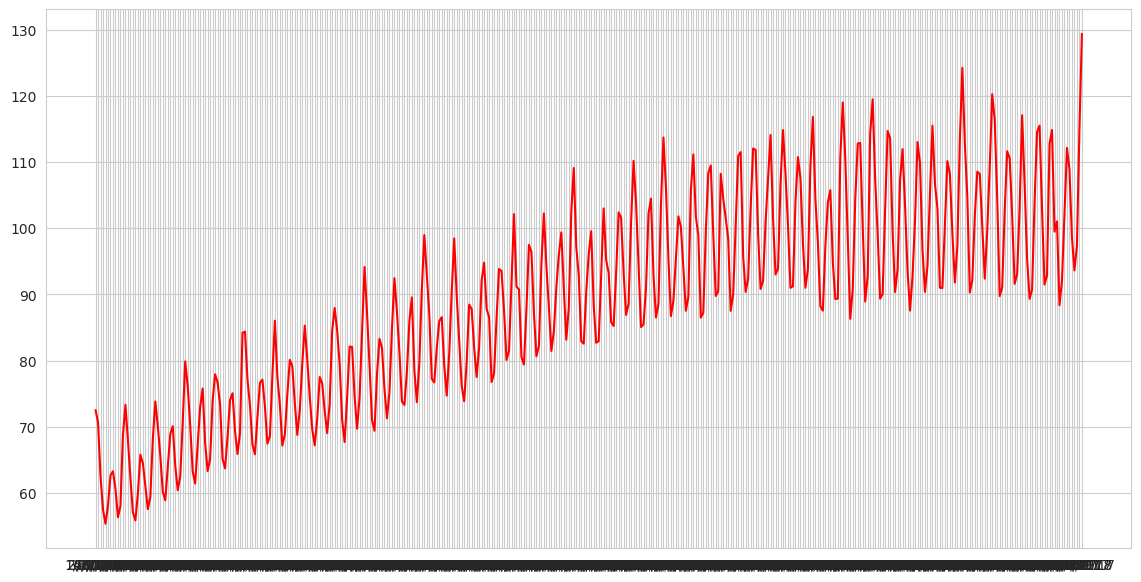

In [4]:
plt.figure(figsize=(14,7))
plt.plot(data.DATE.values,data.Production.values,color = 'red')
plt.show()

Rolling Statistics

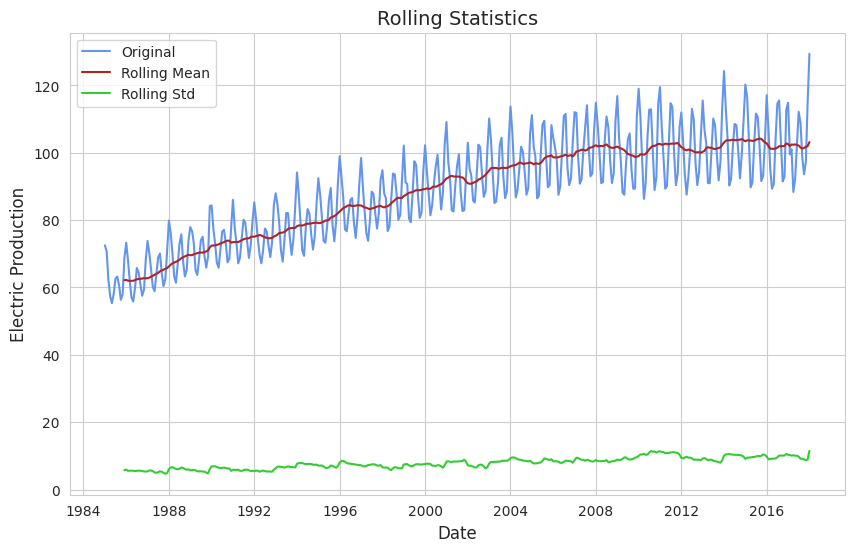

In [5]:
col_names = ["date", "Production"]
data = pd.read_csv('/content/Electric_Production.csv',
                   names=col_names, header=0, parse_dates=[0])
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
data = data.set_index(['date'])

rolling_mean = data.rolling(window=12).mean()
rolling_std = data.rolling(window=12).std()

plt.figure(figsize=(10, 6))
plt.plot(data, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size=12)
plt.ylabel('Electric Production', size=12)
plt.legend(loc='upper left')
plt.title('Rolling Statistics', size=14)
plt.show()

Checking Stationarity

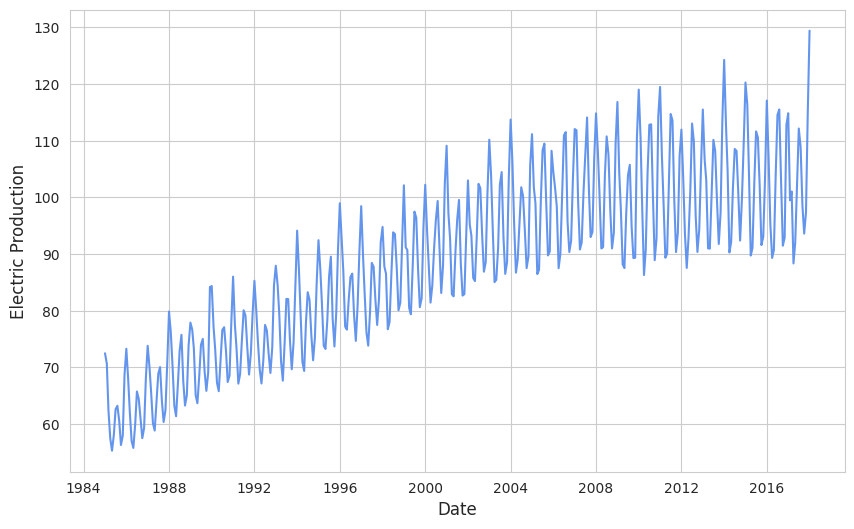

In [6]:
plt.figure(figsize = (10,6))
plt.plot(data['Production'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

In [7]:
print("Data Shape: {}".format(data.shape))
value_1 = data[0:199]
value_2 = data[200:397]

Data Shape: (397, 1)


Mean of Data

In [8]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))
print("Mean of value_2: {}".format(round(value_2.mean()[0],3)))

Mean of value_1: 77.497
Mean of value_2: 100.258


Variance of Data

In [9]:
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Variance of value_1: 123.226
Variance of value_2: 91.677


**Augmented Dickey-Fuller Test**

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

**Null Hypothesis:** Time Series is non-stationary. It gives a time-dependent trend.
**Alternate Hypothesis:** Time Series is stationary. In another term, the series doesn’t depend on time.

ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.

ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

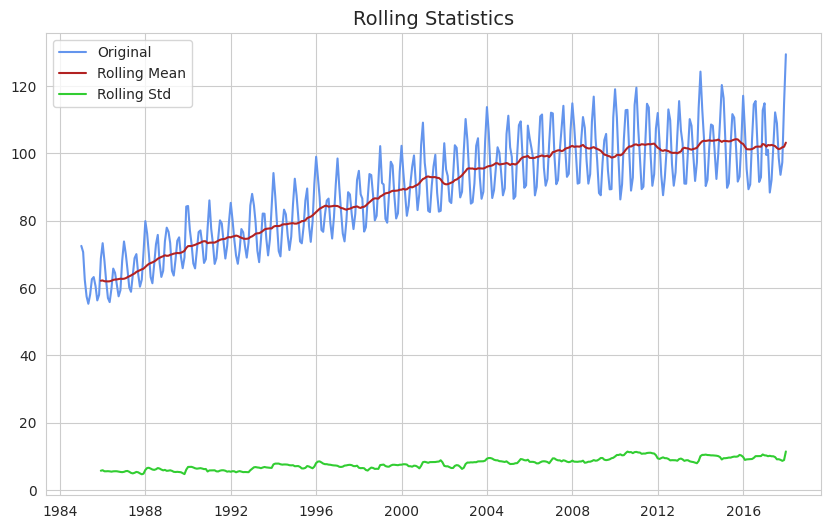

ADF Statistic: -2.257
p-value: 0.186
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [10]:
def adfuller_test(ts, window = 12):

    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()

    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)

    adf = adfuller(ts, autolag='AIC')

    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")
    print('Critical Values:')

    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")

    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")

adfuller_test(data, window = 12)

The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.

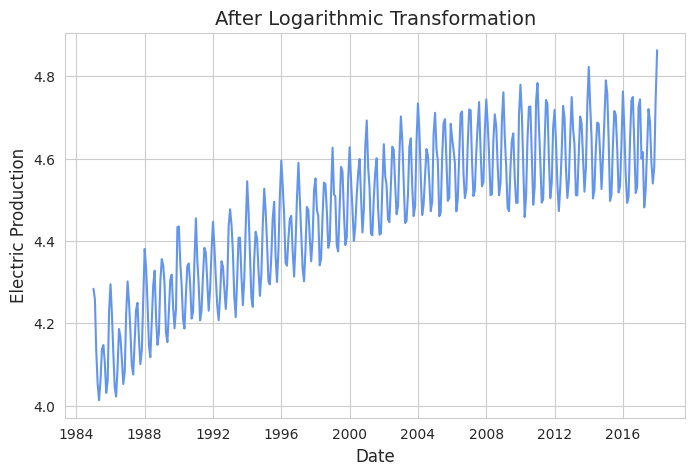

In [11]:
df_log_scaled = data
df_log_scaled['Production'] = boxcox(df_log_scaled['Production'], lmbda=0.0)
plt.figure(figsize = (8,5))
plt.plot(df_log_scaled, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Logarithmic Transformation", size = 14)
plt.show()

Removing Trend with Moving Average

A time series with a trend is called non-stationary.

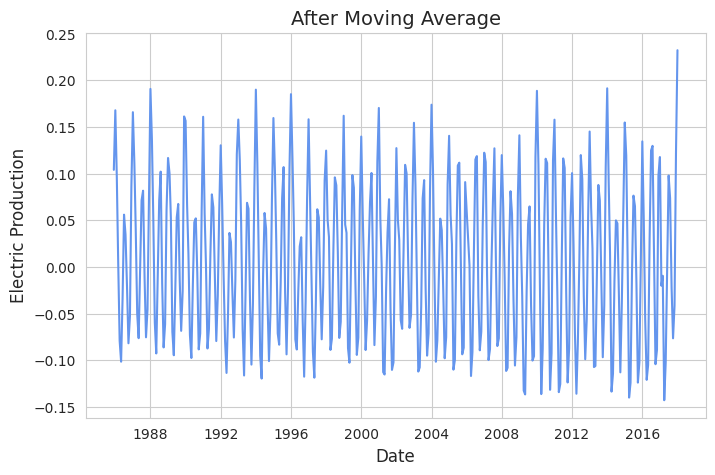

In [12]:
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace=True)
plt.figure(figsize = (8,5))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

Let's test stationarity again.

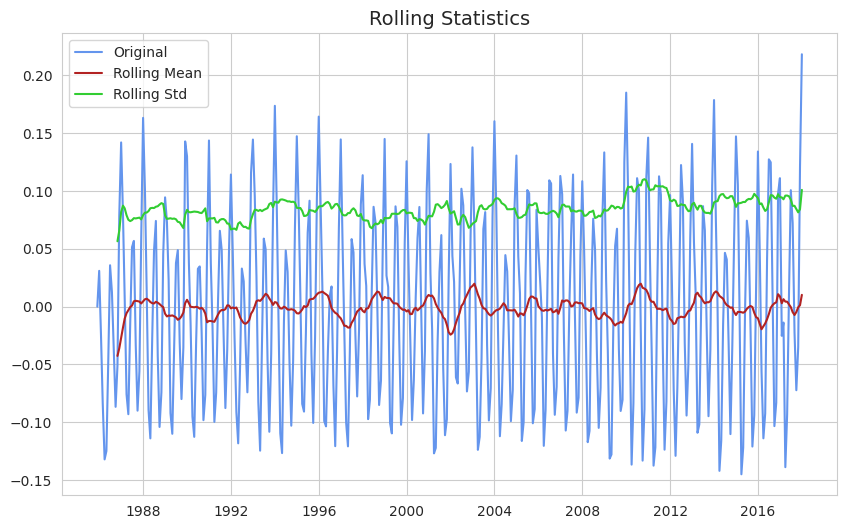

ADF Statistic: -7.213
p-value: 0.0
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [13]:
df_log_scaled_ma_ed = df_log_scaled_ma.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_lsma_sub_df_lsma_ed = df_log_scaled_ma - df_log_scaled_ma_ed
adfuller_test(df_lsma_sub_df_lsma_ed, window = 12)

Decomposition

### Implementing ARIMA Model

### Making time series stationary

#### As we know that the ARIMA models take three parameter values p, q, and d, so before training the model, I will find the values for each of these terms. The d here represents the number of differencing it takes to stationary the time series. So, I will now apply the 1-st differencing to see if the time-series data becomes stationary.

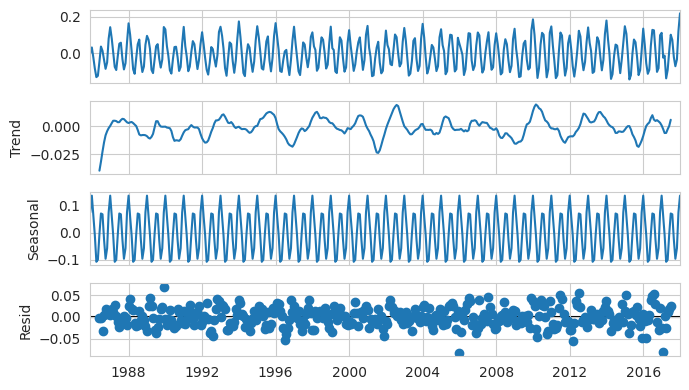

In [14]:
rcParams['figure.figsize']=7,4
df_seasonal_decompose = seasonal_decompose(df_lsma_sub_df_lsma_ed,
                                           model='duplicative')
df_seasonal_decompose.plot()
plt.show()

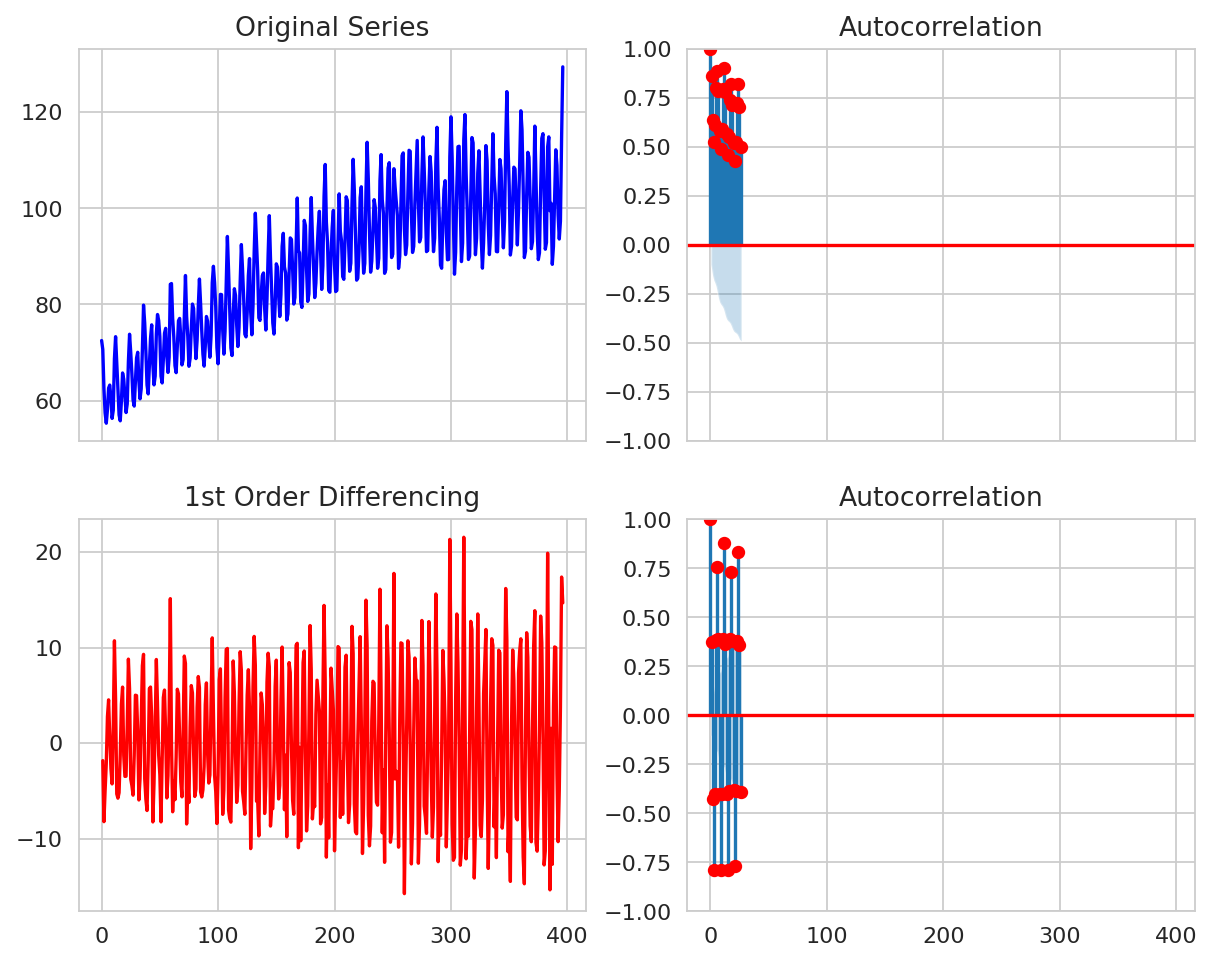

In [15]:
# Importing the modules
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data = pd.read_csv('/content/Electric_Production.csv')
data.rename(columns={'IPG2211A2N': 'Production'}, inplace=True)
# fixing the size
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':160})

# Original Series
fig, axes = plt.subplots(2, 2, sharex=True)
axes[0, 0].plot(data.Production,color='blue'); axes[0, 0].set_title('Original Series')
plot_acf(data.Production, ax=axes[0, 1],color='red')

# 1st Differencing to make stationary time series data
axes[1, 0].plot(data.Production.diff(),color='red'); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.Production.diff().dropna(), ax=axes[1, 1],color ='red')
plt.show()
plt.show()

### From the graph we observed that the time series becomes nearly stationary in the first differencing. So, I will set the value of d equal to 1.

### Finding the order of the AR model

### As we know, the ARIMA model combines the AR and MA models. So, first, let us find the order of the AR model.

### I will determine the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

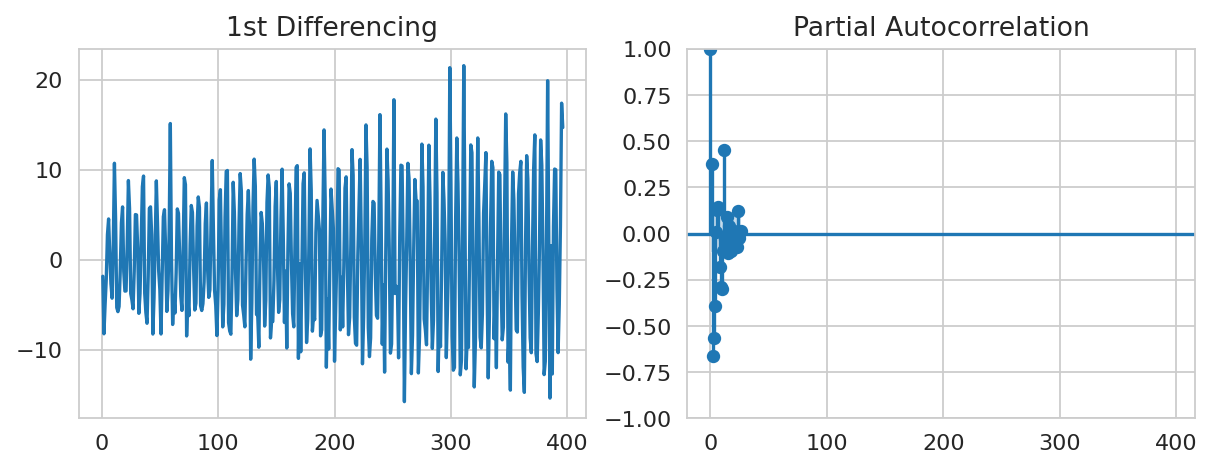

In [16]:
#importing modules
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':160})

# fixing the axis
fig, axes = plt.subplots(1, 2, sharex=True)

# plotting on differen axis
axes[0].plot(data.Production.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
# plotting partial autocorrelation function
plot_pacf(data.Production.diff().dropna(), ax=axes[1])
plt.show()

### In the Partial autocorrelation plot, the light blue area shows the significant threshold value, and every vertical line indicates the PACF values at each time spot.

### So in the plot, only the vertical lines that exceed the light blue area are considered significant. I can see that PACF lag 1 is significant since it is well above the signature line. So, we will set the p value equal to 1.

### Finding the order of the MA model

### An ACF (autocorrelation function) is a correlation between the observations at the current time spot and those at previous time spots. Like how I looked at the PACF plot for the number of AR terms, I will look at the ACF plot for the number of MA terms. An MA term is simply the error of the lagged forecast.

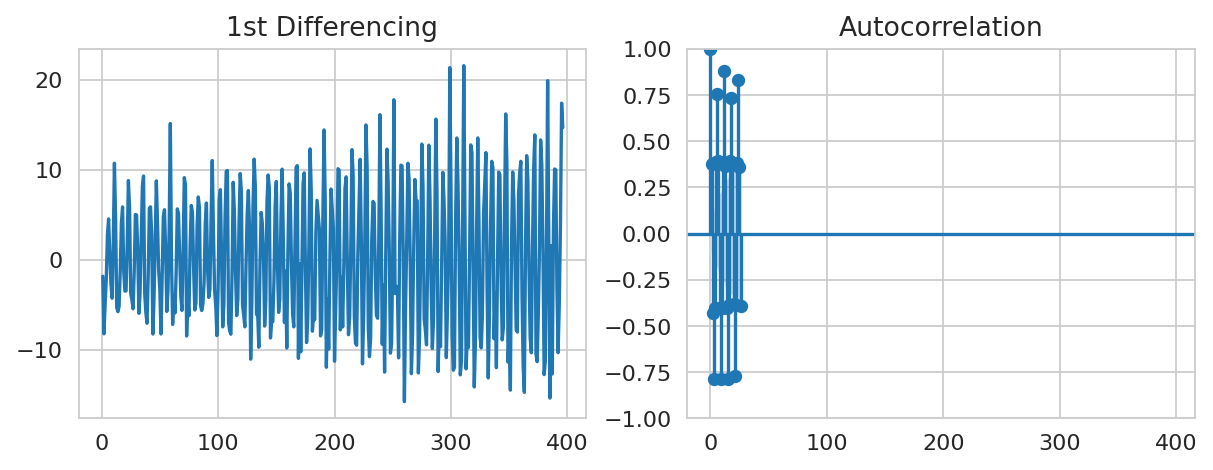

In [17]:
# setting the size
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':160})
#  fixing the subplots
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.Production.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
# plotting the autocorrelation function
plot_acf(data.Production.diff().dropna(), ax=axes[1])
plt.show()

### I can see that couple of lags are well above the signature line, but I will fix q to 1 one vertical line is quite significant in the plot.

### Building the ARIMA model


In [18]:
# importing the ARIMA model
import statsmodels.api as sm
import statsmodels
ARIMA = statsmodels.tsa.arima.model.ARIMA
# 1,1,1 ( arima p d q )
model =  ARIMA(data.Production, order=(1,1,1))
# Training arima modeling
model_fit = model.fit()

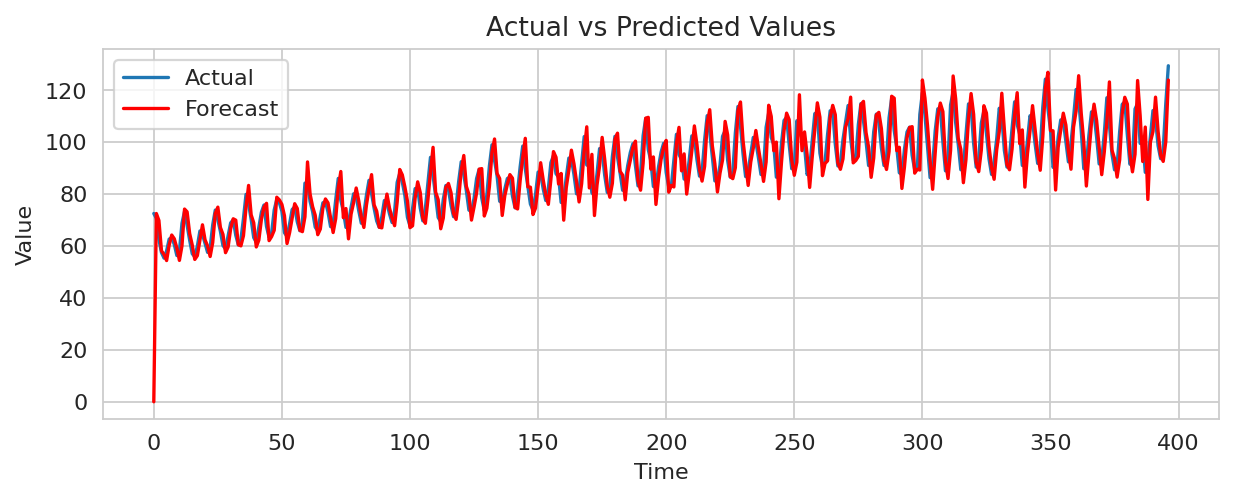

In [19]:
# arima model results
forecast = model_fit.predict(dynamic=False)

plt.plot(data.Production.values, label='Actual')
plt.plot(forecast, color='red', label='Forecast')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

### The blue line shows the predicted values, and the red line shows the actual values. The prediction seems to follow the trend, and it seems to have a decent ARIMA model. But, we can’t say this is the best ARIMA model because we haven’t forecasted the future and compared the forecast with the actual performance.

### Out-of-Time cross-validation
### In Out-of-Time cross-validation, we move backward in time and forecast into the future. Then we can compare the forecast and the actual values to see how well the predictions are

In [20]:
# Create Training and Test
train = data.Production[:200]
test = data.Production[200:]

In [21]:
#  Build Model
model = ARIMA(train, order=(1, 1, 1))
fitted = model.fit()

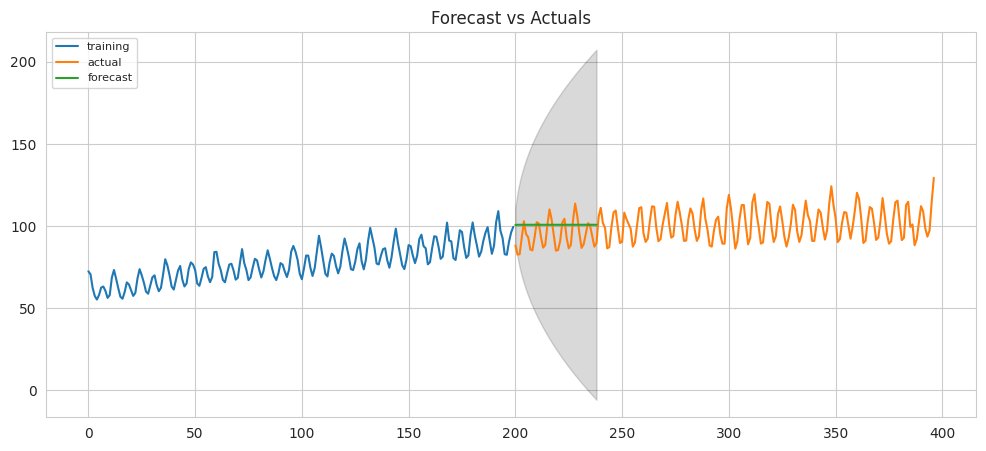

In [22]:
# Forecast using 95% confidence interval
fc = fitted.get_forecast(steps=39, alpha=0.05)

# Extract forecast values and confidence intervals
fc_series = pd.Series(fc.predicted_mean, index=test.index)
conf_int = fc.conf_int()

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### The green line shows the predicted values while the orange shows the actual values, and the grey region represents the confidence interval. We can see from the plot that the model has performed well.

ARIMA MSE: 0.0134


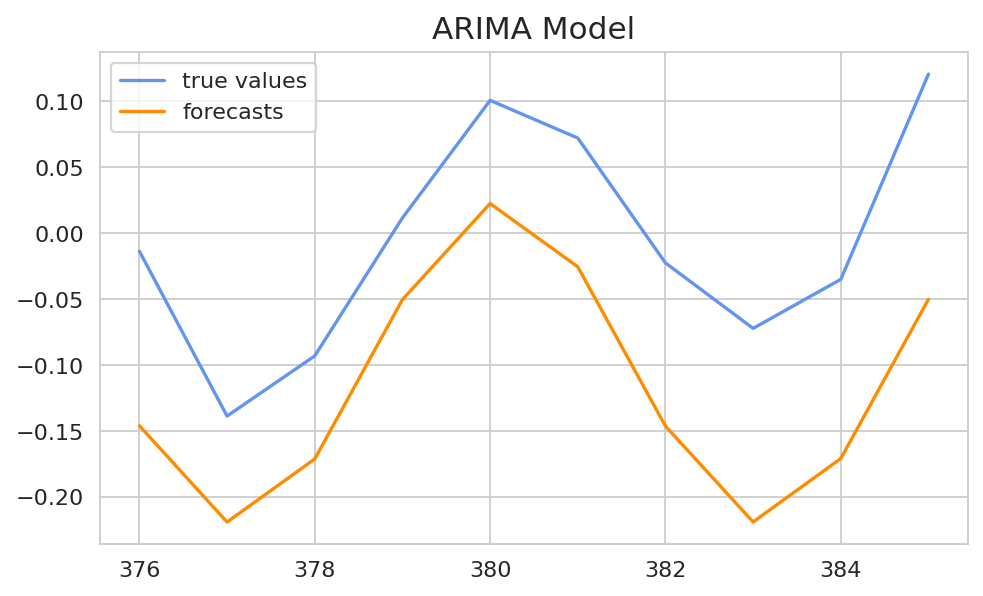

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

values = DataFrame(df_lsma_sub_df_lsma_ed.values)
persistence_df = concat([values.shift(1), values], axis=1)
persistence_df.columns = ['t-1', 't+1']
per_values = persistence_df.values

# Create a DataFrame
values = pd.DataFrame(per_values, columns=['t-1', 't+1'])

# Select only the 't-1' column for training and testing
train = values['t-1'][:-10]
test = values['t-1'][-10:]

# Fit ARIMA model
model = ARIMA(train, order=(2, 1, 2))
ARIMA_model = model.fit()

# Make predictions
predictions = ARIMA_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Calculate mean squared error
arima_score = mean_squared_error(test, predictions)
print('ARIMA MSE: {}'.format(round(arima_score, 4)))

# Plotting
plt.figure(figsize=(7, 4))
plt.plot(test, label="true values", color="cornflowerblue")
plt.plot(predictions, label="forecasts", color='darkorange')
plt.title("ARIMA Model", size=14)
plt.legend(loc='upper left')
plt.show()
